# ASHG Abstract Analysis - Using NCBI Word Vectors and ETM Clustering

This notebook contains an interactive analysis of ASHG 2019 abstracts using NLP tools.
The notebook consists of the following sections:
    1. Introduction to Word Embeddings
    2. Introduction to Topic Modeling and ETM
    3. Overview of the Analysis
    4. Interactive Topic Exploration

If you are only interested in the analysis, feel free to skip to section 3.

This notebook python package requirements can be installed using the attached requirements.txt file, using the command:

pip install -r requirements.txt

# 1. Introduction to Word Embeddings

Word embeddings are a collection of vectors, one for each word, that capture the relationships between the words.
They are trained on large text corpora with the objective of ensuring that related words are close together in the multidimensional space spanned by the vectors. We are using word embeddings that were trained at NCBI on PubMeb data so that we will have access to a biology-related vocabulary (paper: https://www.nature.com/articles/s41597-019-0055-0, repo: https://github.com/ncbi-nlp/BioSentVec).

In order to see how the word embeddings work, we first load them into memory using the gensim library. We have to make a function call to glove2word2vec to put the embeddings in the right format so that we can read them with gensim.

In [1]:
import os

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec


word_embeddings_file_name = os.path.join('data', 'bio_embeddings_abridged.txt')
word_embeddings_path = os.path.join(os.getcwd(), word_embeddings_file_name)
glove_file = datapath(word_embeddings_path)
tmp_file = get_tmpfile("tmp_word2vec.txt")
_ = glove2word2vec(glove_file, tmp_file)
word_embeddings = KeyedVectors.load_word2vec_format(tmp_file)

We can check how many words are in our vocabulary and what the dimensionality of our embeddings is.

In [2]:
print('Vocabulary Size: {}'.format(len(word_embeddings.vocab)))
print('Embedding Dimension Size: {}'.format(word_embeddings.vector_size))

Vocabulary Size: 10000
Embedding Dimension Size: 200


When performing our analysis, we used a vocabulary size of 2 million. However, appending a word embedding file of that size to this report would make it difficult to distribute, so we limited the vocabulary to the one shown above for the sake of this demo.

As mentioned earlier, related words should be close together in the embedding space. We can verify that by calculating the cosine similarity between different words in the space. Consider the following words:
    1. tumor
    2. cancer
    3. marrow
    4. colon
    5. skin
    6. tissue
    7. mutation
    8. variant
    9. disease
    10. asthma
    11. lung
    12. cardiovascular
    13. diabetes

Let's compare the similarity between tumor and cancer and tumor and foot.

In [3]:
tumor_cancer_similarity = word_embeddings.similarity('tumor', 'cancer')
print('Cosine similarity between tumor and cancer: {}'.format(tumor_cancer_similarity))

tumor_foot_similarity = word_embeddings.similarity('tumor', 'asthma')
print('Cosine similarity between tumor and foot: {}'.format(tumor_foot_similarity))

Cosine similarity between tumor and cancer: 0.6079611778259277
Cosine similarity between tumor and foot: 0.23794543743133545


As we would expect, the embedding space appropriately captures that the word tumor is more closely related to the word cancer than to the word asthma.

If we would like to better understand the relationships between the words above in the space, we can use TSNE to compress the 200 dimensions down to 2 dimensions and then plot the words.

In [4]:
import numpy as np
from sklearn.manifold import TSNE

random_seed = 333
np.random.seed(random_seed)


tsne = TSNE(n_components=2)
compressed_word_embeddings = tsne.fit_transform(word_embeddings.vectors)

In [5]:
words = ['tumor', 'cancer', 'marrow', 'colon', 'skin', 'tissue', 'mutation', 'variant', 'bone', 'asthma', 'lung', 'cardiovascular', 'artery']
vocabulary = list(word_embeddings.vocab.keys())
indices = [vocabulary.index(word) for word in words]

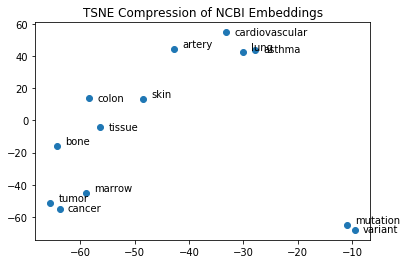

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

points = compressed_word_embeddings[indices]
fig, ax = plt.subplots()
plt.title('TSNE Compression of NCBI Embeddings')
ax.scatter(points[:, 0], points[:, 1])
offset = 1.5
for i, word in enumerate(words):
    ax.annotate(word, (points[i, 0] + offset, points[i, 1] + (-1) ** i * offset))
plt.show()

We must keep in mind that looking at the embeddings after they have been compressed by TSNE will not give a full picture of their internal representation. However, the graph does produce some desired results. Words that co-occur very frequently or are closely related are are very close in the space: variant and mutation, tumor and cancer, cardiovascular and artery, lung and asthma. In general, the more anatomy grounded terms congregate on the left diagonal while the genetics terms are in the bottom right left. Looking deeper at the words on the left, we see a certain continuum where a word like bone which is more closely linked to marrow and skin than they are to each other appears in between them.

One final way to investigate these word embeddings is by observing how some notion of compositionality is preserved in the embedding space. Below, we print the 10 words most similar to the word heart. Then, we add the vector for the word disease to the word heart and observe the 6 words most similar to this summed vector. Watch what happens to the words cardiovascular and congestive.

In [7]:
lung_vector = word_embeddings.get_vector('lung')
print('Words most similar to lung:')
print(word_embeddings.similar_by_vector(lung_vector, 10))
print()

disease_vector = word_embeddings.get_vector('disease')
new_vector = lung_vector + disease_vector
print('Words most similar to the sum of lung and disease')
print(word_embeddings.similar_by_vector(new_vector, 10))

Words most similar to lung:
[('lung', 1.0), ('lungs', 0.8030645251274109), ('pulmonary', 0.7151790857315063), ('bronchial', 0.7052528858184814), ('airways', 0.6942763328552246), ('emphysema', 0.665022611618042), ('bronchoalveolar', 0.6437886357307434), ('bronchus', 0.6355775594711304), ('non-small', 0.6338291764259338), ('ards', 0.6205604076385498)]

Words most similar to the sum of lung and disease
[('lung', 0.8543660640716553), ('disease', 0.8068228960037231), ('lungs', 0.677479088306427), ('diseases', 0.6739617586135864), ('pulmonary', 0.672015905380249), ('emphysema', 0.6609828472137451), ('copd', 0.6510324478149414), ('sarcoidosis', 0.6404048204421997), ('airways', 0.6290620565414429), ('bronchial', 0.6172652840614319)]


If you look at the change in the nearest neighbors when the disease word vector is added to the lung word vector, you might notice that some respitory diseases that previously did not make the top ten nearest neighbors now do, namely, copd and sarcoidosis. On the other hand, while we would have expected a similar amplifying effect for emphysema, that relationship was left more or less the same. Regardless, this demonstrates that the space does to some extent allow for composing meaning from multiple words using vector addition. Similar experiments have demonstrated that combining vector addition and subtraction can also yield semantically meaningful word vectors.

# 2. Introduction to Topic Modeling and ETM

Topic modeling is a generative statistical approach that imagines that documents are written by randomly selecting words from topics. Positing this model allows us to discover what the topics are (which words they are associated with) and to what extent each document was generated using each topic. The Embedded Topic Model (ETM) approach is a special version of topic modeling that allows us to use word embeddings to represent the words (paper: https://arxiv.org/pdf/1907.04907.pdf, repo: https://github.com/adjidieng/ETM). This is extremely helpful in a domain like this one where the vocabulary is highly specialized and complicated because even though the collection of abstracts that we will be training the model on is relatively small (~3000), we can take advantage of all the information gleaned from PubMed that is stored in the word embeddings.

The following is a brief example of the generative process that we image created the document. While this is certainly not the actual process that generated our documents, our assumption allows us to work backwards to solve for the topics.

Imagine that we have a vocabulary of 12 words. We also have 2 topics, sports and fashion. Each topic is a discrete probability distribution over the words in the vocabulary. The sports topic will allocated more probability mass to words like game or point while the fashion topic will do the same for shirt and jeans. They both will allocate sizeable probability mass to jacket, sneakers, and ball (for fashion this is because of the compound word ball gown).

In [8]:
vocabulary = ['ball',
              'gown',
              'jacket',
              'sandals',
              'sneakers',
              'shirt',
              'jeans',
              'dress',
              'bat',
              'game',
              'point',
              'playoff']

sports_probabilities = [.15, .001, .1, .01, .12, .03, .001, .001, .12, .177, .16, .13]
fashion_probabilities = [.07, .10, .143, .06, .12, .17, .15, .18, .001, .003, .002, .001]

We assume that documents are generated by first choosing how many words will be in the document. In this example, we assume 8. Then, for every word, we draw a topic from this document's own distribution over topics. The topic we draw, sports or fashion, will determine which distribution over words we use to draw this particular word.

In [9]:
distribution_over_topics = [.7, .3]

In [10]:
import numpy as np

random_seed = 0
np.random.seed(random_seed)

document = []
n_words = 8
for i in range(n_words):
    topic_index = np.random.multinomial(1, distribution_over_topics).argmax()
    if topic_index == 0:
        distribution_over_words = sports_probabilities
    else:
        distribution_over_words = fashion_probabilities
    word_index = np.random.multinomial(1, distribution_over_words).argmax()
    document.append(vocabulary[word_index])

print('Document:')
print(document)

Document:
['game', 'bat', 'shirt', 'game', 'playoff', 'ball', 'point', 'sneakers']


The produced document is a mixture of sports and fashion / clothes terminology. The balance skews towards sports terms which reflects the higher probability mass of the sports topic in the document's original distribution.

While the documents we want to analyze are significantly more complicated than this toy example, we still assume that they are generated by this type of process, albeit with far more topics and words to choose from.

This allows use to implement a maximum likelihood approximator for parameter distributions that we can approximate with a variational bayes approach. The approximator will yield parameter values for each topic distribution over words and for each document distribution over topics. This will allow us to interpret each topic and by extension gain insights into the documents we are analyzing.

# 3. Overview of the Analysis

We used the implementation of ETM found in https://github.com/adjidieng/ETM and then made changes to the code to improve our results. Of most importance, we altered the prior distributions to induce less sparsity in document distributions over topics and more sparsity in topic distributions over words. This has the effect of making topics more specific and using more different topics to explaing each document.

Prior to running the algorithm, we prunned words that appeared in more that 30% of documents (assuming these wouldn't contain differentiating information) and words that only appeared in a single document (assuming it would be difficult to find a pattern in the collection from words that only appear in one abstract). These prunning values were chosen following extensive experimentation.

We ran the ETM algorithm for 150 epochs with various hyperparameter settings. The model presented here was selected for having produced the most easily interpretable topics. We used a learning rate of .005 and assumed that there were 125 topics.

Below we define some of our hyperparameter settings and load our data.

In [11]:
min_df = 2
n_topics = 125

In [12]:
import data

vocab, train, valid, test = data.get_data(os.path.join('data', 'ashg_min_df_{}'.format(min_df)))

Below, we load our raw text and permute it so that it has the same order that was used to train the model. We only do this so that we can easily connect the raw text to the indices in the model's internal representation of the text.

In [13]:
corpus_path = os.path.join('raw', 'ASHG-2019.v2.txt')
document_conference_ids = []
titles = []
abstracts = []
corpus = []

with open(corpus_path, 'r') as f:
    for line in f:
        tab_split_text = line.split('\t')
        document_conference_ids.append(tab_split_text[0])
        titles.append(tab_split_text[1])
        abstracts.append(' '.join(tab_split_text[2:]))
        text = ' '.join(tab_split_text[1:])
        corpus.append(text.split())
        
random_seed = 0
np.random.seed(random_seed)
idx_permute = np.random.permutation(len(corpus)).astype(int)
titles = np.array(titles, dtype=object)[idx_permute]
abstracts = np.array(abstracts, dtype=object)[idx_permute]

We load the encoded version of the text, both the indexed tokens and the count for each token.

In [14]:
import scipy.io

train_token_file_path = os.path.join('data', 'ashg_min_df_{}'.format(min_df), 'bow_tr_tokens.mat')
train_count_file_path = os.path.join('data', 'ashg_min_df_{}'.format(min_df), 'bow_tr_counts.mat')
val_token_file_path = os.path.join('data', 'ashg_min_df_{}'.format(min_df), 'bow_va_tokens.mat')
val_count_file_path = os.path.join('data', 'ashg_min_df_{}'.format(min_df), 'bow_va_counts.mat')
test_token_file_path = os.path.join('data', 'ashg_min_df_{}'.format(min_df), 'bow_ts_tokens.mat')
test_count_file_path = os.path.join('data', 'ashg_min_df_{}'.format(min_df), 'bow_ts_counts.mat')
train_tokens = scipy.io.loadmat(train_token_file_path)['tokens'].squeeze()
train_counts = scipy.io.loadmat(train_count_file_path)['counts'].squeeze()
val_tokens = scipy.io.loadmat(val_token_file_path)['tokens'].squeeze()
val_counts = scipy.io.loadmat(val_count_file_path)['counts'].squeeze()
test_tokens = scipy.io.loadmat(test_token_file_path)['tokens'].squeeze()
test_counts = scipy.io.loadmat(test_count_file_path)['counts'].squeeze()
tokens = np.concatenate([train_tokens, val_tokens, test_tokens])
counts = np.concatenate([train_counts, val_counts, test_counts])

We encode the documents as counts of word frequencies that our model will translate into distributions over topics.

In [15]:
import torch

doc_ids = np.arange(len(corpus))
docs = np.zeros((len(doc_ids), len(vocab)))
for i, doc_id in enumerate(doc_ids):
    doc = tokens[doc_id]
    count = counts[doc_id]
    L = count.shape[1]
    if len(doc) == 1: 
        doc = [doc.squeeze()]
        count = [count.squeeze()]
    else:
        doc = doc.squeeze()
        count = count.squeeze()
    if doc_id != -1:
        for j, word in enumerate(doc):
            docs[i, word] = count[j]
docs = torch.from_numpy(docs).float()

We load the pretrained model.

In [16]:
trained_model_path = os.path.join('results', 'etm_ashg_min_df_{}_K_{}_Htheta_800_Optim_adam_Clip_0.0_ThetaAct_relu_Lr_0.005_Bsz_1000_RhoSize_200_trainEmbeddings_0'.format(min_df, n_topics))

In [17]:
with open(trained_model_path, 'rb') as f:
    model = torch.load(f, map_location='cpu')

Next, we prepare the model parameters that we estimated to pass them to a program that can help us visualize them.

Betas are the topics. It is a matrix where each row (each topic) is a distribution over words. That means each row sums to 1. Looking at the high probability words should give us an idea of what each topic is about.

Thetas are the documents / abstracts. It is a matrix where each row (each document) is a distribution over topics. Again, each row will sum to 1. Looking at the high probability topics in this case will tell us which topics a certain abstract falls under

In [18]:
with torch.no_grad():
    betas = model.get_beta().cpu().numpy()
    thetas = model.get_theta(docs)[0].cpu().numpy()

In [19]:
term_frequency_by_document = np.zeros((tokens.shape[0], len(vocab)))
for i in range(tokens.shape[0]):
    term_frequency_by_document[i][tokens[i]] = counts[i]
term_frequency = term_frequency_by_document.sum(0)

In [20]:
abstracts_model_data = {
    'topic_term_dists': betas,
    'doc_topic_dists': thetas,
    'doc_lengths': [count.sum() for count in counts],
    'vocab': vocab,
    'term_frequency': term_frequency
}

In [21]:
import pyLDAvis

abstracts_vis_data = pyLDAvis.prepare(mds='tsne', **abstracts_model_data)

# Topic Visualization

The widget below allows you to visualize the topics in a TSNE reduced space. You can scroll through the topics with the buttons on top or you can directly click on them. Doing so will bring that topic's distribution into focus on the right, showing which words were assigned high probability for this topic. The display on the right will also give you access to a relevance slider. I recommend playing with this for topics of interest. Lower values of lambda will emphasize words that feature more prominently in this topic relative to other topics. This allows you to see what makes the topic in question unique. The recommended value for lambda is 0.6

The size of each topic corresponds to how much overall probability mass it was assigned (how much it is assumed to have contributed to the generation of our collection of abstracts). Smaller topics have fewer documents associated with them.

In [22]:
pyLDAvis.display(abstracts_vis_data)

As you look through these topics, you will notice that they vary in how useful the information they contain is. Some topics, such as Topic 1, contain very mundane information. Words like medical, care, medicine, do very little to help us differentiate between different abstracts. More general topics like this one are used by the model to explain the more mundane language in the abstracts. We are interested in finding the smaller, more specific topics, association with which will set documents apart.

I encourage you to look through all the topics. However, the following is my brief overview of the topics to help guide your analysis. I bold all the topics I find interesting and specific enough to be meaningful. Some descriptions are left blank if I struggled to summarize the distribution. Keep in mind that my interpretations of the topics are subjective.

**All Topics**

1	 Medical fluff words

2	 Genetic study language

**3	 Cancer, cancer-related language, and cancer-prone organs**

4	 Research fluff words

**5	 Detection-related language**

**6	 Nervous system and development**

**7	 Cells and cell lines**

**8	 Regulatory networks**

9	 Explanatory language

10	Referencing language

11	Method, algorithm language

12	Methodology, control language

13	Identifying language

**14	Gene expression**

**15	Studies with participants**

16	

**17	Disease or disorder linked**

18	Pattern language

**19	Proteins and transcription**

**20	Major organ systems**

**21	Statistical testing**

**22	Genotype, haplotype, ancestry**

23	Participant description language

**24	Genomic language and inheritance**

25	

**26	Significance and quantification**

**27	Population genetics**

28	

29	

30	

**31	Genomic language and transcription**

**32	Drugs, enzymes, inhibitors**

**33	Causation-implying language**

**34	Pathogens**

**35	Bioinformatics pipeline language**

**36	Interaction effects**

37	

38	

**39	Lipid, cholesterol, and motor cortex**

**40	Platform or framework development**

**41	Mice**

**42	Mediator complex**

43	General health language

**44	Immune system**

45	Statistics language

46	

47	

**48	Phenotype**

49	

**50	Molecular, structural**

51	Sampling

**52	Genome region language**

53	

54	

55	High, low language

**56	Biomarkers**

57	Presentation language

58	

**59	Treatment and response**

**60	Robust and scalable tools**

61	

**62	Binding region**

63	Quantity language

64	Score language

65	Hypothesis, investigate

66	Effect

**67	System development**

**68	Causal associations**

**69	Significance and interpretability**

**70	Simulation**

71	Affect

**72	Shared sequences**

**73	Mathematical models**

74	

75	Comparison language

**76	Facial and cardiovascular**

77	Statistics results language

78	Conducting experiment language

79	

80	Frequency language

81	Evaluation language

82	Presenting results language

83	

84	Categorization language

85	Conducting experiment language

86	

**87	Outliers, bias, pruning**

**88	Software tools**

89	Cohort descriptions

**90	Neuro-developmental (autism)**

91	

92	Tumor

**93	Viral or bacterial infection**

**94	Rare, congenital disorders**

95	

96	

**97	Blood**

98	

99	

100	

101	Quantity

**102	Enrichment, discovery**

103	Statistical results language

104	Statistical results language

**105	Humanoid**

106	

107	Findings

108	

109	

**110	Cognitive, neurological linked**

111	Time language

112	Frequency

**113	Common diseases and conditions (asthma, diabetes, schizophrenia, alcohol use and cirrhosis, smoking, drug use)**

114	

**115	Diagnosis**

116	

**117	Pediatric**

118	

**119	Database, curated annotations**

120	

121	Insight

122	Variation

123	Mutation

124	

125	

**Topics I Found of Note**

**3	 Cancer, cancer-related language, and cancer-prone organs**

**5	 Detection-related language**

**6	 Nervous system and development**

**7	 Cells and cell lines**

**8	 Regulatory networks**

**14	Gene expression**

**15	Studies with participants**

**17	Disease or disorder linked**

**19	Proteins and transcription**

**20	Major organ systems**

**21	Statistical testing**

**22	Genotype, haplotype, ancestry**

**24	Genomic language and inheritance**

**26	Significance and quantification**

**27	Population genetics**

**31	Genomic language and transcription**

**32	Drugs, enzymes, inhibitors**

**33	Causation-implying language**

**34	Pathogens**

**35	Bioinformatics pipeline language**

**36	Interaction effects**

**39	Lipid, cholesterol, and motor cortex**

**40	Platform or framework development**

**41	Mice**

**42	Mediator complex**

**44	Immune system**

**48	Phenotype**

**50	Molecular, structural**

**52	Genome region language**

**56	Biomarkers**

**59	Treatment and response**

**60	Robust and scalable tools**

**62	Binding region**

**67	System development**

**68	Causal associations**

**69	Significance and interpretability**

**70	Simulation**

**72	Shared sequences**

**73	Mathematical models**

**76	Facial and cardiovascular**

**87	Outliers, bias, pruning**

**88	Software tools**

**90	Neuro-developmental (autism)**

**93	Viral or bacterial infection**

**94	Rare, congenital disorders**

**97	Blood**

**102	Enrichment, discovery**

**105	Humanoid**

**110	Cognitive, neurological linked**

**113	Common diseases and conditions (asthma, diabetes, schizophrenia, alcohol use and cirrhosis, smoking, drug use)**

**115	Diagnosis**

**117	Pediatric**

**119	Database, curated annotations**

# 4. Interactive Topic Exploration

This portion is meant to provide functions for you to look further into the data.

## Example 1

Having identified the topics discovered by the ETM model, we can use them to better understand our documents.

Choose a topic that you find interesting from the list above and enter in below as the topic id. The relevance parameter is the lambda value from chart above. You can set it to a value between 0 and 1.

The n_words parameter will determine how many of the topics high probability words are displayed.

In order to find associated documents, we set the document_threshold to a value between 0 and 1. Any document whose topic distribution has probability mass in excess of the threshold assigned to the topic we choose will be listed. This gives us a list of documents to look into.  The number of topics returned will vary wildly based on the threshold as well as the size of the topic itself. Some very small topics will require setting the threshold very low (.01 or lower) to get any documents.

As an example, I am using topic id 19 (proteins and transcription).

In [23]:
topic_id = 19
relevance_parameter = .6
n_words = 10
document_threshold = .05

This function assumes that model, docs, and abstracts_vis_data have been defined earlier in the notebook. The topic_reordering is just an array that allows us to reorder the topics in the same way that the pyLDAvis widget did so that our topic ids line up.

In [24]:
topic_reordering = np.arange(len(abstracts_vis_data.topic_order))[np.array(abstracts_vis_data.topic_order) - 1]

def print_topic_info(topic_id, relevance_parameter=0.6, n_words=10, document_threshold=.05):
    with torch.no_grad():
        theta = model.get_theta(docs)[0].cpu().numpy()
        k = topic_reordering[topic_id - 1]
        beta = model.get_beta()[k]
        relevance_normalized_beta = relevance_parameter * beta.log() + (1 - relevance_parameter) * (beta / (1. / docs.sum()) * docs.sum(0)).log()
        top_words = list(relevance_normalized_beta.cpu().numpy().argsort()[-n_words:][::-1])
        topic_words = [vocab[a] for a in top_words]
        topic_words.append(' '.join(topic_words))
        n_documents = (theta[:, k] > document_threshold).sum()
        if n_documents > 0:
            top_documents = list(theta[:, k].argsort()[-n_documents:][::-1])
        else:
            top_documents = []
        print('Topic {}: {}\n'.format(topic_id, topic_words))
        print('Top Document Ids for Topic {}: {}\n'.format(topic_id, top_documents))

In [25]:
print_topic_info(topic_id, relevance_parameter, n_words, document_threshold)

Topic 19: ['protein', 'regulatory', 'proteins', 'transcription', 'expression', 'regulation', 'encodes', 'splicing', 'transcripts', 'domain', 'protein regulatory proteins transcription expression regulation encodes splicing transcripts domain']

Top Document Ids for Topic 19: [2643, 2617, 1155, 1476, 3253, 2214, 1001, 918, 1430, 2118, 251, 714, 2687, 641, 2290, 283, 3149, 125]



Now, we can look further into some of the returned documents. The function define below will print the title and abstract from document id you pass it. It also lists the n_topics highest probability topics for this document, allowing you to see other ways in which this topic is topically categorized. 

In [26]:
document_id = 2643
n_topics = 10

In [27]:
def print_doc_info (document_id, n_topics=10):
    with torch.no_grad():
        theta = model.get_theta(docs)[0].cpu().numpy()
        topic_probabilities = theta[document_id][topic_reordering]
        probability_indices = topic_probabilities.argsort()[-n_topics:][::-1]
        print('Document Distribution Over Topics:\n')
        for i in probability_indices:
            print('Topic {}: {}'.format(i + 1, round(topic_probabilities[i], 3)))
        print()
    print('Document Conference Id: {}\n'.format(document_conference_ids[document_id]))
    print('Document Title: {}\n'.format(titles[document_id]))
    print('Document Abstract: {}\n'.format(abstracts[document_id]))

In [28]:
print_doc_info(document_id, n_topics)

Document Distribution Over Topics:

Topic 19: 0.11699999868869781
Topic 24: 0.03400000184774399
Topic 6: 0.032999999821186066
Topic 7: 0.03099999949336052
Topic 8: 0.029999999329447746
Topic 32: 0.02800000086426735
Topic 52: 0.027000000700354576
Topic 20: 0.027000000700354576
Topic 34: 0.02500000037252903
Topic 33: 0.02500000037252903

Document Conference Id: PgmNr 859

Document Title: AON-mediated exon skipping to bypass protein truncation in retinal dystrophies due to the recurrent CEP290 c.4723A > T mutation.

Document Abstract:  Introduction and Purpose: Mutations in CEP290 encoding a centrosomal protein important to cilia formation and maintenance cause a spectrum of diseases, from retinal dystrophies to multivisceral ciliopathies. In recent years, splicing regulation involving variable mechanisms e.g. endogenous and selective non-canonical exon skipping have shown to contribute to CEP290 pleiotropy. This observation led us to consider targeted exon skipping to bypass protein trun

As expected given the topic, this abstract characterizes the relationship between a mutation and a specific protein. If we would like to understand some of this abstract's other topical assignments, we can look at the topics in the widget above or by calling the print_topic_info function. Let's look further into Topic 8.

In [29]:
topic_id = 8
print_topic_info(topic_id)

Topic 8: ['involved', 'regulatory', 'pathways', 'pathway', 'mechanisms', 'process', 'key', 'regulation', 'essential', 'critical', 'involved regulatory pathways pathway mechanisms process key regulation essential critical']

Top Document Ids for Topic 8: [1109]



I referred to Topic 8 as a regulatory network topic above. If we look at the abstract for PgmNr 859, we see that the authors refer to recent work characterizing the relationship between splicing regulation and pleiotropy in their gene of interest.

## Example 2

As another example, let's say we were interested in Topic 119 (database, curated annotations). Let's examine it.

In [30]:
topic_id = 119
relevance_parameter = 1.0
document_threshold = .015
print_topic_info(topic_id, relevance_parameter=relevance_parameter, document_threshold=document_threshold)

Topic 119: ['read', 'annotation', 'reads', 'database', 'datasets', 'databases', 'dataset', 'annotations', 'annotated', 'curation', 'read annotation reads database datasets databases dataset annotations annotated curation']

Top Document Ids for Topic 119: [2829, 562, 2767, 2433, 3266, 2203, 1150, 1576, 2321, 2759]



I picked a couple of the documents listed to see how well they match the topic.

In [31]:
document_id = 2433
print_doc_info(document_id)

Document Distribution Over Topics:

Topic 1: 0.2879999876022339
Topic 4: 0.10700000077486038
Topic 15: 0.08100000023841858
Topic 43: 0.06199999898672104
Topic 35: 0.041999999433755875
Topic 49: 0.027000000700354576
Topic 38: 0.027000000700354576
Topic 11: 0.026000000536441803
Topic 21: 0.024000000208616257
Topic 40: 0.019999999552965164

Document Conference Id: PgmNr 246

Document Title: Behind the scenes of submission processing at ClinVar.

Document Abstract:  ClinVar is a public database of submitted interpretations of variants and their relationships to disease, maintained by the National Center for Biotechnology Information (NCBI) at the National Institutes of Health (NIH). Many kinds of data are submitted to ClinVar by many types of organizations. Thus the ClinVar team uses both automated and manual steps to validate, aggregate, and add value to submitted data. Automated validation includes checking consistency of variant and gene data; validating database identiﬁers for conditio

The above paper is literally introducing a new database, which is a perfect fit for the topic.

In [32]:
document_id = 2321
print_doc_info(document_id)

Document Distribution Over Topics:

Topic 1: 0.3529999852180481
Topic 15: 0.1340000033378601
Topic 4: 0.1080000028014183
Topic 43: 0.09200000017881393
Topic 35: 0.039000000804662704
Topic 21: 0.020999999716877937
Topic 38: 0.019999999552965164
Topic 49: 0.01899999938905239
Topic 11: 0.017000000923871994
Topic 119: 0.014999999664723873

Document Conference Id: PgmNr 2241

Document Title: Curation and quality assessment of 16S rRNA databases through natural language processing.

Document Abstract:  A fundamental step in genomic and metagenomic data analyses is taxonomic annotation, which maps sequences onto known taxonomies, using tools such as Blast, HMMER and others. The underlying computational algorithm has an eﬀect on the taxonomic assignment, but precision is also greatly inﬂuenced by the quality of the reference database. In the context of 16S rRNA sequencing there is a wide collection of curated and uncurated databases, including RDP, GRD, Silva, RefSeq and Core but it isn’t alwa

The above paper combines discussion of databases and curation, both of which were high probability terms for Topic 119.

## Example 3

Finally, let's look at a different use case. Let's assume that we start with a document and we want to see how our system would label it topically. In this case, we will start with document id 881.

In [33]:
document_id = 881
n_topics = 20
print_doc_info(document_id, n_topics=n_topics)

Document Distribution Over Topics:

Topic 10: 0.019999999552965164
Topic 5: 0.01899999938905239
Topic 4: 0.01899999938905239
Topic 1: 0.017999999225139618
Topic 27: 0.017999999225139618
Topic 13: 0.017000000923871994
Topic 2: 0.01600000075995922
Topic 11: 0.01600000075995922
Topic 21: 0.01600000075995922
Topic 9: 0.01600000075995922
Topic 12: 0.014999999664723873
Topic 15: 0.014999999664723873
Topic 28: 0.014000000432133675
Topic 37: 0.014000000432133675
Topic 49: 0.014000000432133675
Topic 22: 0.014000000432133675
Topic 45: 0.014000000432133675
Topic 54: 0.014000000432133675
Topic 29: 0.014000000432133675
Topic 30: 0.013000000268220901

Document Conference Id: PgmNr 1497

Document Title: The genetic structure and admixture history of Hui population.

Document Abstract:  With a population size of 10.5 million, Hui is the second largest of 55 minorities and the largest of the 10 official Muslim ethnic groups in China. However, the genetic study of Hui population has been underrepresente

The high probability labels correspond to our topic labels. However, as indicated in the earlier analysis, some of the topics mean very little. Let's ignore the ones that I did not bold in my topic description section. That leaves us with topics:
5 (detection-related language),
27 (population genetics),
21 (statistical testing),
15 (studies with participants),
22 (genotype, haplotype, ancestry).

Let's take a look at these topics and see how they fit.

In [34]:
document_threshold = 1.
for topic_id in [5, 27, 21, 15, 22]:
    print_topic_info(topic_id, document_threshold=document_threshold)

Topic 5: ['detection', 'screening', 'prenatal', 'testing', 'fetal', 'maternal', 'imaging', 'derived', 'combined', 'combining', 'detection screening prenatal testing fetal maternal imaging derived combined combining']

Top Document Ids for Topic 5: []

Topic 27: ['individuals', 'population', 'populations', 'participants', 'subjects', 'ethnic', 'people', 'biobank', 'biobanks', 'ancestry', 'individuals population populations participants subjects ethnic people biobank biobanks ancestry']

Top Document Ids for Topic 27: []

Topic 21: ['testing', 'power', 'statistics', 'test', 'precision', 'tests', 'error', 'detection', 'standard', 'accuracy', 'testing power statistics test precision tests error detection standard accuracy']

Top Document Ids for Topic 21: []

Topic 15: ['participants', 'records', 'individuals', 'subjects', 'hearing', 'people', 'survey', 'retrospective', 'experience', 'students', 'participants records individuals subjects hearing people survey retrospective experience stude

The abstract does mention detecting admixture events, but that type of detection is somewhat different from the type suggested by the other words in Topic 5, so we can say that Topic 5 only partially fits.

The abstract is all about population genetics and determining ancestry, so Topic 27 is a perfect fit.

The fact that the abstract speaks of clusters, infering, and detecting events suggests usage of statistical testing, making Topic 21 somewhat fitting.

As suggested by Topic 15, the abstract does present findings on a new set of individuals which the abstract does briefly describe.

Finally, the abstract's mention of haplotype-based methods to infer ancestry makes it fit nicely into Topic 22.

## I encourage you to continue digging into the topics to better understand what types of documents they encapsulate.

In [38]:
with torch.no_grad():
    thetas = model.get_theta(docs)[0].cpu().numpy()

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
twod_docs = pca.fit_transform(thetas)

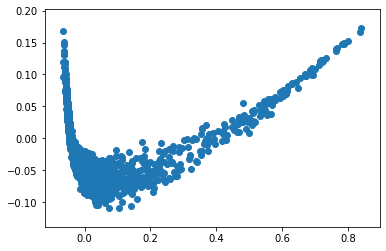

In [44]:
from matplotlib import pyplot as plt

plt.scatter(twod_docs[:, 0], twod_docs[:, 1])
plt.show()